## Schwarchild modeling

In [92]:
%reload_ext autoreload
%autoreload 2

# Imports

import pickle

import jax
import jaxopt
import jax.numpy as jnp
from functools import partial

import time as tt
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

from potentials import *
from integrants import *
from utils import *

In [3]:
# Initial conditions 

params_halo = {
    'logM': 11.64,
    'Rs':16.,
    'a':1.0,
    'b':1.0,
    'c':1.0,
    'x_origin':0.0,
    'y_origin':0.0,
    'z_origin':0.0,
    'dirx':0.0,
    'diry':0.0,
    'dirz':1.0
}

params_disk = {
    'logM': 10.84,
    'Rs': 3.0,
    'Hs': 0.28,
    'x_origin': 0.0,
    'y_origin': 0.0,
    'z_origin': 0.0,
    'dirx': 0.0,
    'diry': 0.0,
    'dirz': 1.0
}

params_bar = {
    'A': jnp.fabs(MiyamotoNagai_potential(0, 0, 0, params_disk)),
    'Rs': 4.0,
    'Hs': 0.5,
    'Omega': 35.0,
    't0': 0.5,
    't1': 1.5,
    'x_origin': 0.0,
    'y_origin': 0.0,
    'z_origin': 0.0,
    'dirx': 0.0,
    'diry': 0.0,
    'dirz': 1.0
}

@jax.jit
def acc_fn(x, y, z, t, params_halo, params_disk, params_bar):
    a_halo = NFW_acceleration(x, y, z, params_halo)
    a_disk = MiyamotoNagai_acceleration(x, y, z, params_disk)
    a_bar  = Bar_acceleration(x, y, z, t, params_bar)
    return a_halo + a_disk + a_bar

with open('./ic_thin_1015.pickle', 'rb') as f:
    ic_thin = pickle.load(f)
w0_thin = jnp.array([ic_thin['x'], ic_thin['y'], ic_thin['z'], ic_thin['vx'], ic_thin['vy'], ic_thin['vz']]).T

with open('./ic_thick_1015.pickle', 'rb') as f:
    ic_thick = pickle.load(f)
w0_thick = jnp.array([ic_thick['x'], ic_thick['y'], ic_thick['z'], ic_thick['vx'], ic_thick['vy'], ic_thick['vz']]).T

n_particles = 10000
w0_thin = w0_thin[:n_particles]
w0_thick = w0_thick[:n_particles]

time = 4.
n_steps = 1000
dt = time / n_steps
unroll = False

In [4]:
t_thin, xv_thin = jax.vmap(integrate_leapfrog_traj, in_axes=(0, None, None, None, None, None, None, None, None))\
                            (w0_thin, params_halo, params_disk, params_bar, acc_fn, n_steps, dt, 0.0, False)

angles_thin = -t_thin * params_bar['Omega']
xv_thin = jax.vmap(jax.vmap(go_to_bar_ref, in_axes=(0, 0)), in_axes=(0, 0))(xv_thin, angles_thin)

In [5]:
t_thick, xv_thick = jax.vmap(integrate_leapfrog_traj, in_axes=(0, None, None, None, None, None, None, None, None))\
                            (w0_thick, params_halo, params_disk, params_bar, acc_fn, n_steps, dt, 0.0, False)

angles_thick = -t_thick * params_bar['Omega']
xv_thick = jax.vmap(jax.vmap(go_to_bar_ref, in_axes=(0, 0)), in_axes=(0, 0))(xv_thick, angles_thick)

Text(0, 0.5, 'z [kpc]')

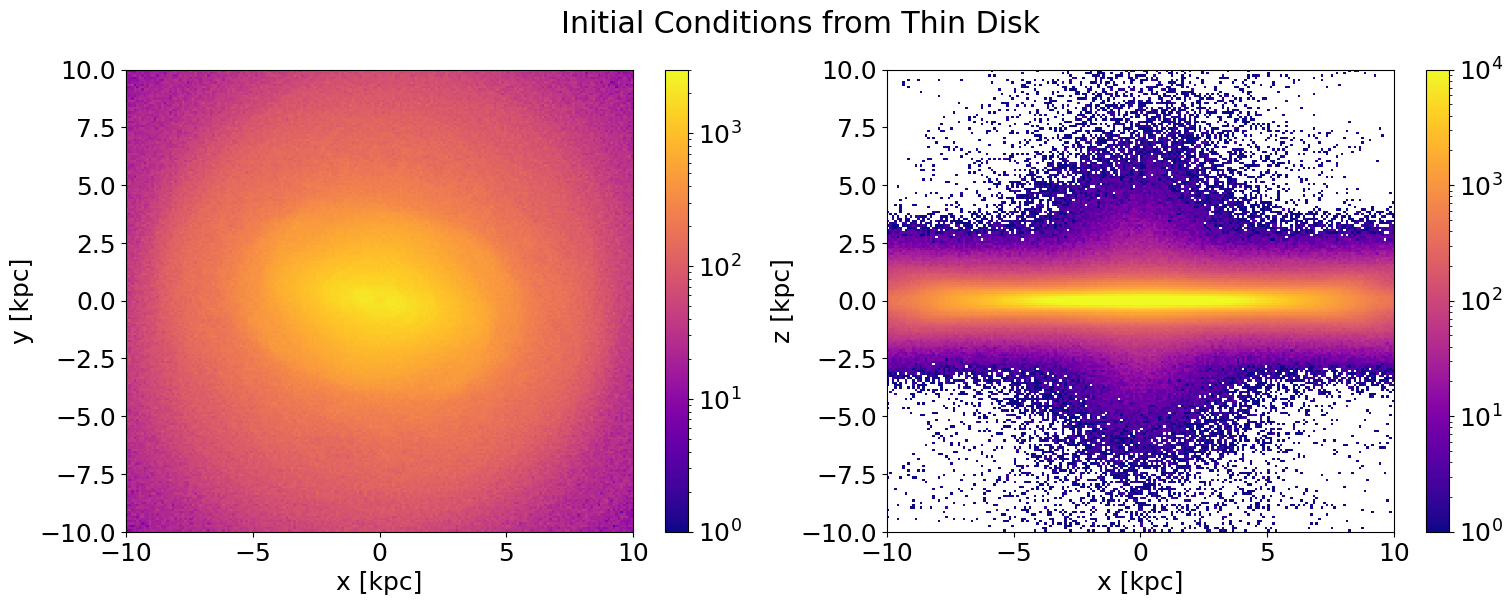

In [64]:
plt.figure(figsize=(18,6))
plt.suptitle('Initial Conditions from Thin Disk')
plt.subplot(1,2,1)
Hxy_true, xedge, yedge,_ = plt.hist2d(xv_thin[:,:,0].flatten(), xv_thin[:,:,1].flatten(), 
            bins=200, range=[[-10,10],[-10,10]], cmap='plasma', norm='log', vmin=1, vmax=3*1e3)
plt.colorbar()
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.subplot(1,2,2)
Hxz_true, xedge, yedge,_ = plt.hist2d(xv_thin[:,:,0].flatten(), xv_thin[:,:,2].flatten(), 
            bins=200, range=[[-10,10],[-10,10]], cmap='plasma', norm='log', vmin=1, vmax=1e4)
plt.colorbar()
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')

Text(0, 0.5, 'z [kpc]')

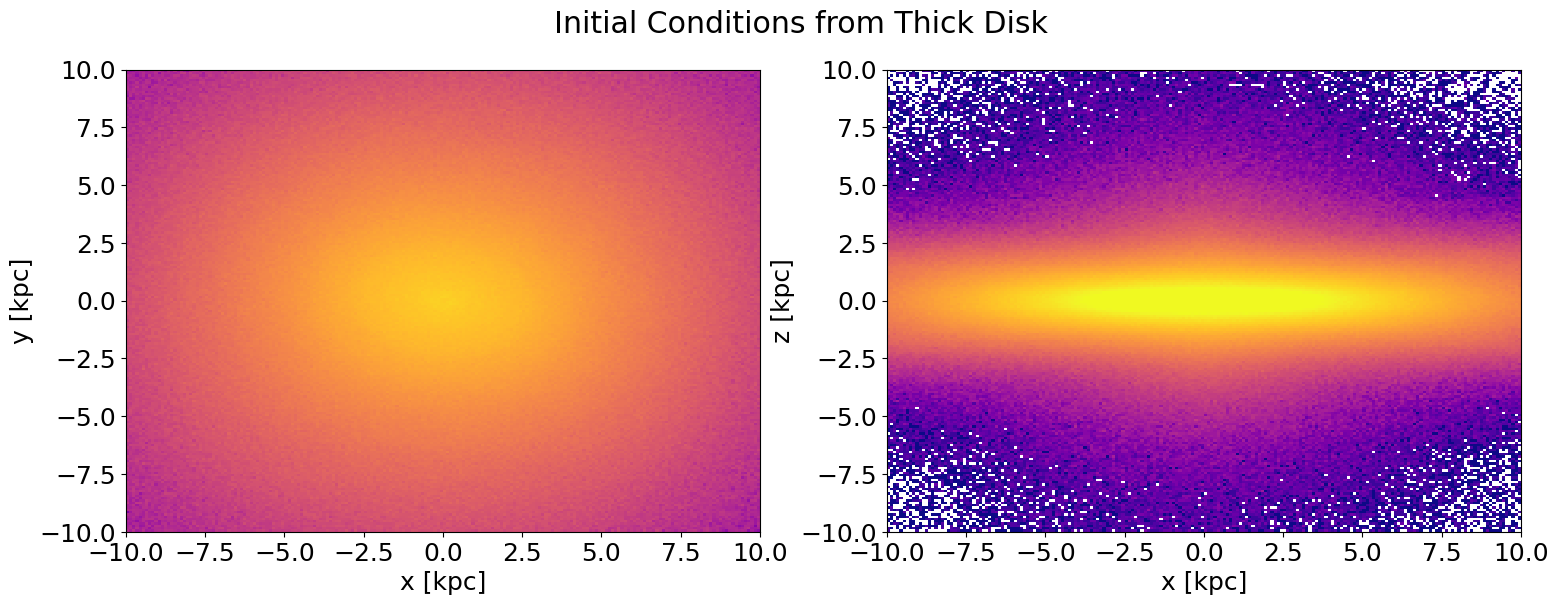

In [122]:
plt.figure(figsize=(18,6))
plt.suptitle('Initial Conditions from Thick Disk')
plt.subplot(1,2,1)
Hxy_false, xedge, yedge,_  = plt.hist2d(xv_thick[:,:,0].flatten(), xv_thick[:,:,1].flatten(), 
            bins=200, range=[[-10,10],[-10,10]], cmap='plasma', norm='log', vmin=1, vmax=3*1e3)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.subplot(1,2,2)
Hxz_false, xedge, yedge,_ = plt.hist2d(xv_thick[:,:,0].flatten(), xv_thick[:,:,2].flatten(), 
            bins=200, range=[[-10,10],[-10,10]], cmap='plasma', norm='log', vmin=1, vmax=3*1e3)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')

## Fit weights

We now want to reweight the orbits for the Thick disk to match the density distribution of the Thin disk

In [30]:
original_density = jnp.sum(jax.vmap(histogram3d)(xv_thin[:, :, :3]), axis=0)
density = jnp.sum(jax.vmap(histogram3d)(xv_thin[:, :, :3]), axis=0).reshape(-1)
raw_density = jnp.sum(jax.vmap(histogram3d)(xv_thick[:, :, :3]), axis=0).reshape(-1)
contributions = jax.vmap(histogram3d)(xv_thick[:, :, :3]).reshape(n_particles, -1).T

A = contributions.astype(jnp.float32)
y = density.astype(jnp.float32)
sig = jnp.sqrt(y + 1.0).astype(jnp.float32)  # Poisson noise + 1.0 floor

In [169]:
# === Positive least squares with Gaussian noise (pure JAX) ===
# Pipeline 1: Projected Gradient + Nesterov (FISTA-style), exact step per iteration
# Pipeline 2: Pure-JAX LBFGS with softplus reparameterization (strict x>0)

import jax
import jax.numpy as jnp
import jax.nn as jnn
import jaxopt

@jax.jit
def _nll_z(z, A, y, sig, l2):
    x = jnn.softplus(z)  # strictly positive
    r = (A @ x - y) / sig
    return 0.5 * jnp.dot(r, r) + 0.5 * l2 * jnp.dot(x, x)
_nll_z = jax.value_and_grad(_nll_z)

@jax.jit
def solve_lbfgs_softplus(A, y, sigma, l2=1e-3, maxiter=500, tol=1e-6):
    z0 = jnp.zeros(A.shape[1], A.dtype)
    solver = jaxopt.LBFGS(fun=_nll_z, value_and_grad=True, maxiter=maxiter, tol=tol)
    res = solver.run(z0, A, y, sigma, l2)
    x_hat = jnn.softplus(res.params)
    return x_hat

# --- LBFGS (strictly positive) ---
a = tt.time()
x_lbfgs = solve_lbfgs_softplus(A, y, sig, l2=1e-3, maxiter=300)
b = tt.time()
print("Time taken (LBFGS):", b - a, "s")

Time taken (LBFGS): 0.8338272571563721 s


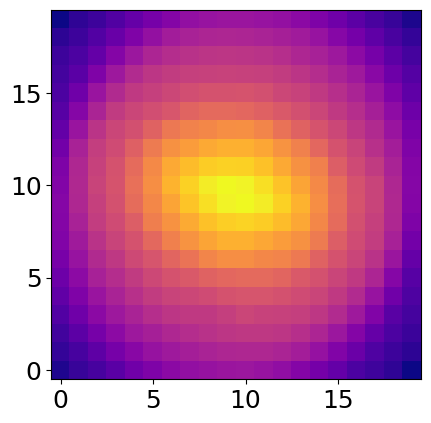

In [28]:
plt.imshow(density.reshape(original_density.shape).sum(axis=2).T, cmap='plasma', norm='log', origin='lower')

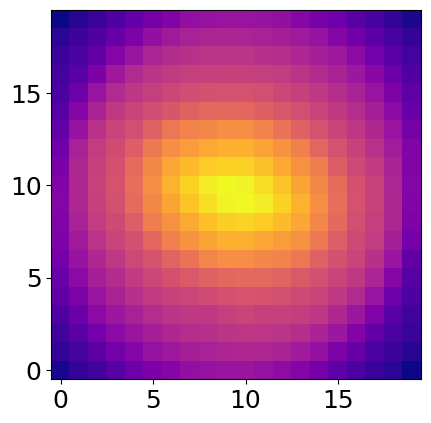

In [29]:
plt.imshow((A@x_lbfgs).reshape(original_density.shape).sum(axis=2).T, cmap='plasma', norm='log', origin='lower')

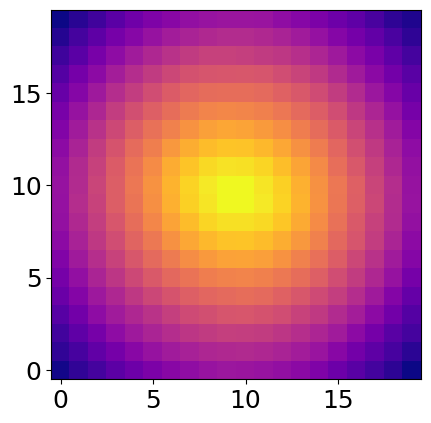

In [31]:
plt.imshow(raw_density.reshape(original_density.shape).sum(axis=2).T, cmap='plasma', norm='log', origin='lower')

In [9]:
y_pred = A@x_lbfgs
weighted_density = xv_thick*x_lbfgs[:,None,None]

Text(0, 0.5, 'z [kpc]')

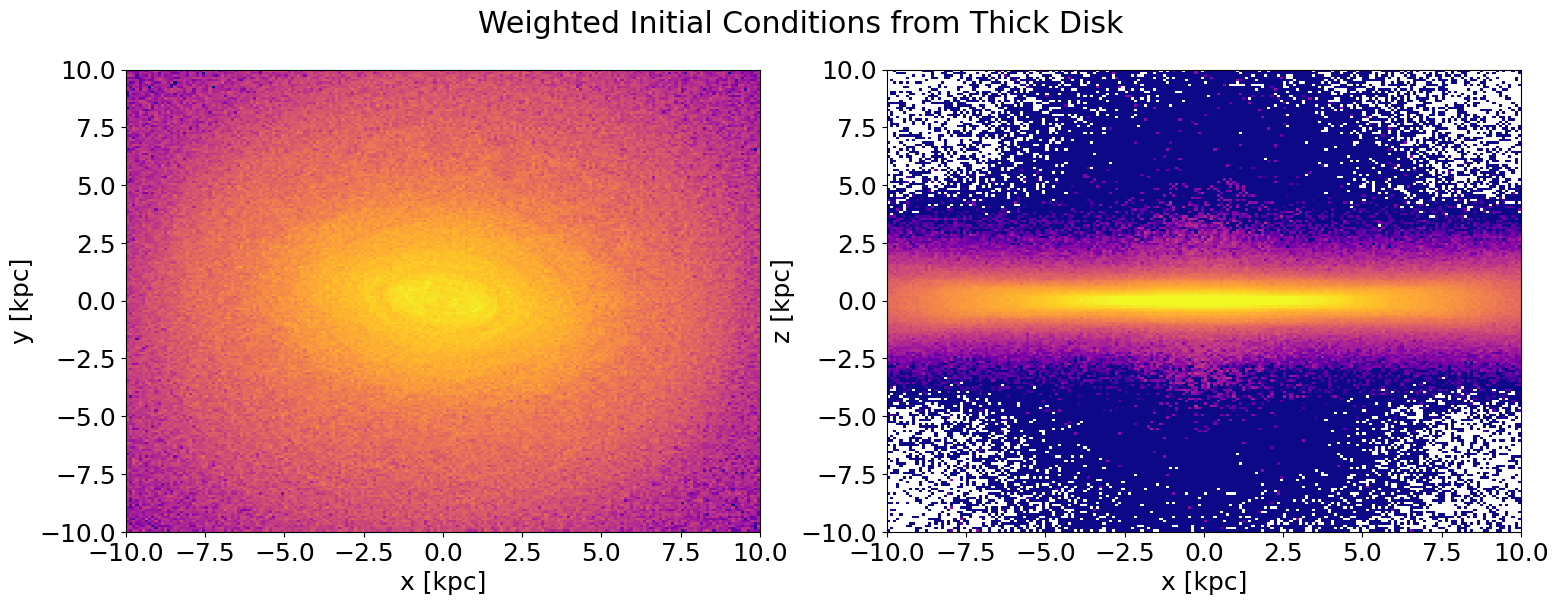

In [121]:
plt.figure(figsize=(18,6))
plt.suptitle('Weighted Initial Conditions from Thick Disk')
plt.subplot(1,2,1)
Hxy, xedge, yedge,_ = plt.hist2d((xv_thick[:,:,0]).flatten(), (xv_thick[:,:,1]).flatten(), 
            bins=200, range=[[-10,10],[-10,10]], cmap='plasma', norm='log', weights=jnp.repeat(x_lbfgs, xv_thick.shape[1]),
            vmin=1, vmax=3*1e3)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.subplot(1,2,2)
Hxz, xedge, yedge,_ = plt.hist2d((xv_thick[:,:,0]).flatten(), (xv_thick[:,:,2]).flatten(), 
            bins=200, range=[[-10,10],[-10,10]], cmap='plasma', norm='log', weights=jnp.repeat(x_lbfgs, xv_thick.shape[1]),
            vmin=1, vmax=1e4)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')

/var/folders/bz/ftchh2fx1mzg7zrsqk32mjp40000gn/T/ipykernel_12923/192344286.py:8: RuntimeWarning: divide by zero encountered in divide
  cb = plt.pcolormesh(xedge, yedge, ((Hxz-Hxz_true)/Hxz_true).T, cmap='coolwarm', vmin = -1, vmax=1)
/var/folders/bz/ftchh2fx1mzg7zrsqk32mjp40000gn/T/ipykernel_12923/192344286.py:8: RuntimeWarning: invalid value encountered in divide
  cb = plt.pcolormesh(xedge, yedge, ((Hxz-Hxz_true)/Hxz_true).T, cmap='coolwarm', vmin = -1, vmax=1)


Text(0, 0.5, 'z [kpc]')

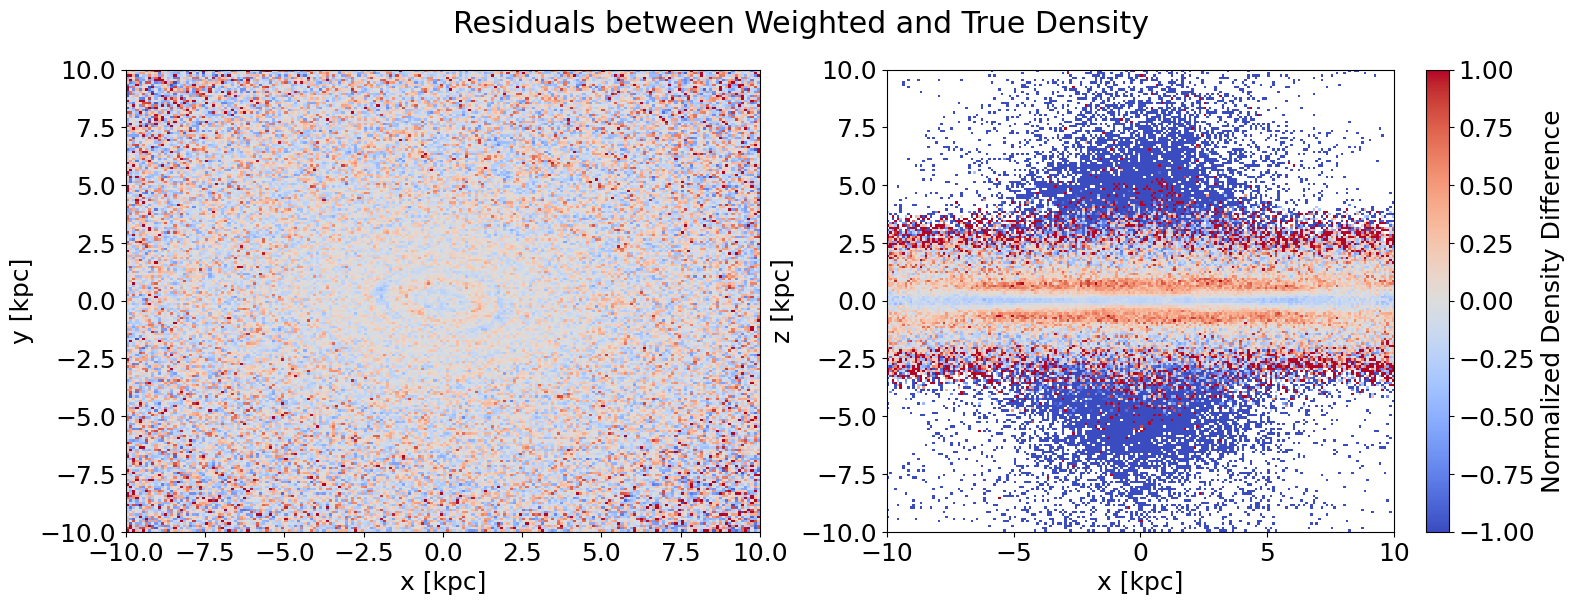

In [114]:
plt.figure(figsize=(18,6))
plt.suptitle('Residuals between Weighted and True Density')
plt.subplot(1,2,1)
cb = plt.pcolormesh(xedge, yedge, ((Hxy-Hxy_true)/Hxy_true).T, cmap='coolwarm', vmin = -1, vmax=1)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.subplot(1,2,2)
cb = plt.pcolormesh(xedge, yedge, ((Hxz-Hxz_true)/Hxz_true).T, cmap='coolwarm', vmin = -1, vmax=1)
plt.colorbar(cb, label='Normalized Density Difference')
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')

/var/folders/bz/ftchh2fx1mzg7zrsqk32mjp40000gn/T/ipykernel_12923/3210805203.py:8: RuntimeWarning: divide by zero encountered in divide
  cb = plt.pcolormesh(xedge, yedge, ((Hxz_false-Hxz_true)/Hxz_true).T, cmap='coolwarm', vmin = -1, vmax=1)
/var/folders/bz/ftchh2fx1mzg7zrsqk32mjp40000gn/T/ipykernel_12923/3210805203.py:8: RuntimeWarning: invalid value encountered in divide
  cb = plt.pcolormesh(xedge, yedge, ((Hxz_false-Hxz_true)/Hxz_true).T, cmap='coolwarm', vmin = -1, vmax=1)


Text(0, 0.5, 'z [kpc]')

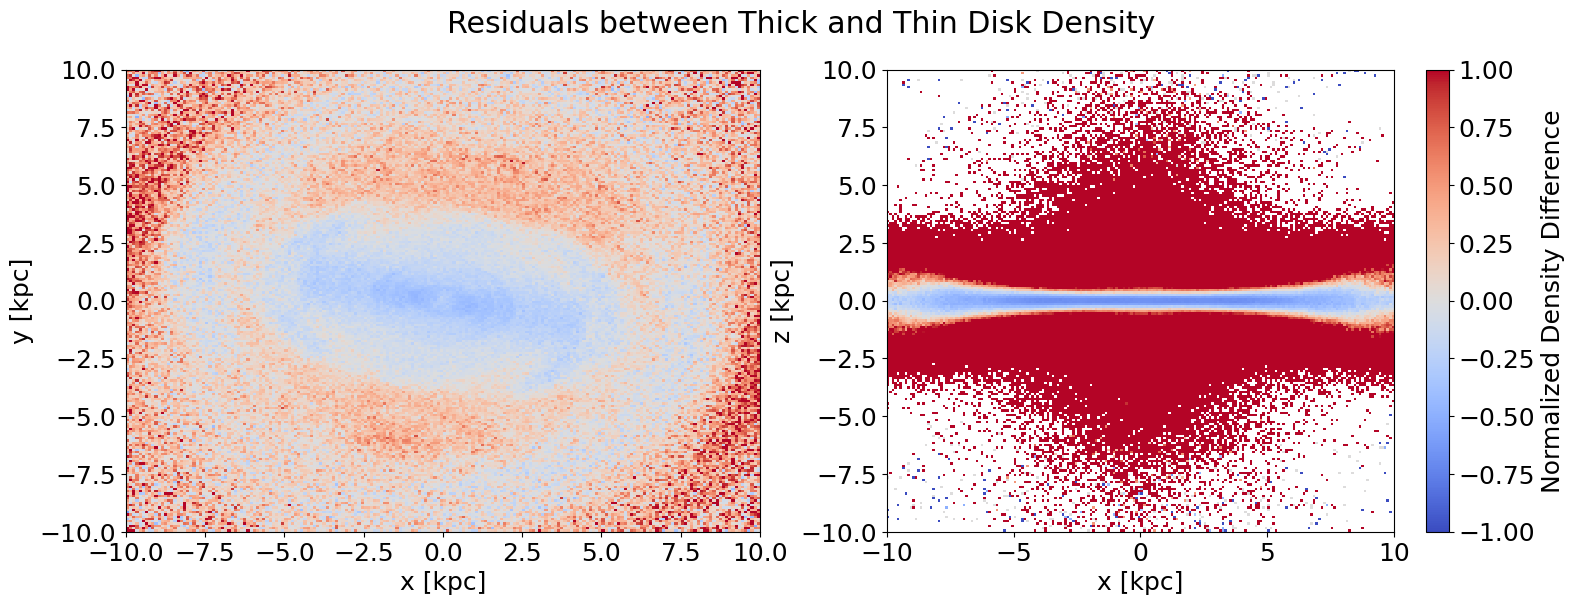

In [124]:
plt.figure(figsize=(18,6))
plt.suptitle('Residuals between Thick and Thin Disk Density')
plt.subplot(1,2,1)
cb = plt.pcolormesh(xedge, yedge, ((Hxy_false-Hxy_true)/Hxy_true).T, cmap='coolwarm', vmin = -1, vmax=1)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.subplot(1,2,2)
cb = plt.pcolormesh(xedge, yedge, ((Hxz_false-Hxz_true)/Hxz_true).T, cmap='coolwarm', vmin = -1, vmax=1)
plt.colorbar(cb, label='Normalized Density Difference')
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')